In [ ]:
# --- 1. 라이브러리 및 모듈 임포트 ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold # ✨ StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split # train_test_split
import joblib
import optuna
import sys
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# 한글 폰트 설정
import matplotlib.font_manager as fm
try:
    font_path = '../../font/NanumFont/NanumGothic.ttf'
    if os.path.exists(font_path):
        fe = fm.FontEntry(fname=font_path, name='NanumGothic')
        fm.fontManager.ttflist.insert(0, fe)
        plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothic'})
    else:
        print("나눔고딕 폰트를 찾을 수 없어 기본 폰트로 설정됩니다.")
except Exception as e:
    print(f"폰트 설정 중 오류 발생: {e}")
    pass


# --- 2. 경로 설정 및 커스텀 로거 임포트 ---

try:
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../../src/log"))
    sys.path.insert(0, src_path)
    from logger import Logger
    print("Logger 모듈 로드 성공.")
except ImportError:
    print("[오류] Logger 모듈을 찾을 수 없습니다.")
    class Logger:
        def __init__(self, *args, **kwargs): pass
        def write(self, message, **kwargs): print(message)
        def start_redirect(self): pass
        def stop_redirect(self): pass
        def close(self): pass


# --- 3. 로거 및 경로 초기화 ---

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
LOG_DIR = '../../data/logs/price_prediction_5_logs'
LOG_FILENAME = f"price_prediction_{timestamp}.log"
LOG_PATH = os.path.join(LOG_DIR, LOG_FILENAME)
os.makedirs(LOG_DIR, exist_ok=True)
logger = Logger(log_path=LOG_PATH)

TRAIN_PATH = '../../data/processed/cleaned_data/train_clean.csv'
TEST_PATH = '../../data/processed/cleaned_data/test_clean.csv'

SUBMISSION_DIR = '../../data/processed/submissions'
SUBMISSION_FILENAME = 'price_prediction_5_submission.csv'
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, SUBMISSION_FILENAME)
os.makedirs(SUBMISSION_DIR, exist_ok=True)

MODEL_DIR = '../../model'
MODEL_FILENAME = 'price_prediction_5_model.pkl'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILENAME)
os.makedirs(MODEL_DIR, exist_ok=True)

logger.write("="*50)
logger.write(">> 아파트 가격 예측 모델링 시작")
logger.write(">> [1-3단계 완료] 라이브러리, 경로, 로거 초기화 성공")


# --- 4. 데이터 로드 ---

logger.write(">> [4단계 시작] 데이터 로드 중...")
try:
    train_df_clean = pd.read_csv(TRAIN_PATH)
    test_df_clean = pd.read_csv(TEST_PATH)
    
    train_df_clean['isTest'] = 0
    test_df_clean['isTest'] = 1
    
    df = pd.concat([train_df_clean, test_df_clean])
    logger.write(">> 데이터 로드 및 병합 완료.")
except FileNotFoundError as e:
    logger.write(f">> [오류] 데이터 파일을 찾을 수 없습니다: {e}", print_error=True)
    df = None

Logger 모듈 로드 성공.
2025-07-16 12:32:14 | ==================================================
2025-07-16 12:32:14 | >> 아파트 가격 예측 모델링 시작
2025-07-16 12:32:14 | >> [1-3단계 완료] 라이브러리, 경로, 로거 초기화 성공
2025-07-16 12:32:14 | >> [4단계 시작] 데이터 로드 중...
2025-07-16 12:32:15 | >> 데이터 로드 및 병합 완료.


In [10]:
# --- 5. 피처 엔지니어링 및 데이터 분리 ---

# --- 5-1. 타겟 변환 (로그 변환) ---
if 'df' in locals() and df is not None:
    logger.write(">> [5-1단계 시작] Target 변수 로그 변환을 시작합니다...")
    train_df = df[df['isTest'] == 0].copy()
    train_df['target'] = np.log1p(train_df['target'])
    df.loc[df['isTest']==0, 'target'] = train_df['target']
    logger.write(">> Target 변수 로그 변환 완료.")


# --- 5-2. 고급 피처 엔지니어링 ---
if 'df' in locals() and df is not None:
    try:
        logger.write(">> [5-2단계 시작] 고급 피처 엔지니어링 및 데이터 분리를 시작합니다...")
        
        train_df = df[df['isTest'] == 0].copy()
        test_df = df[df['isTest'] == 1].copy()
        logger.write(">> 1. Train/Test 데이터 분리 완료.")

        current_year = datetime.now().year
        for temp_df in [train_df, test_df]:
            temp_df['계약월_sin'] = np.sin(2 * np.pi * temp_df['계약월']/12)
            temp_df['계약월_cos'] = np.cos(2 * np.pi * temp_df['계약월']/12)
            temp_df['아파트나이'] = current_year - temp_df['연식']
        logger.write(">> 2. 시간 관련 피처 생성 완료.")

        train_df['면적당가격'] = train_df['target'] / train_df['전용면적']
        
        dong_price_stats = train_df.groupby('법정동')['면적당가격'].agg(['mean', 'std']).reset_index()
        dong_price_stats.columns = ['법정동', '동별_평균면적당가격', '동별_면적당가격편차']
        gu_price_stats = train_df.groupby('자치구')['면적당가격'].agg(['mean', 'std']).reset_index()
        gu_price_stats.columns = ['자치구', '구별_평균면적당가격', '구별_면적당가격편차']
        
        train_df = pd.merge(train_df, dong_price_stats, on='법정동', how='left')
        test_df = pd.merge(test_df, dong_price_stats, on='법정동', how='left')
        train_df = pd.merge(train_df, gu_price_stats, on='자치구', how='left')
        test_df = pd.merge(test_df, gu_price_stats, on='자치구', how='left')
        logger.write(">> 3. 면적당 가격 관련 피처 생성 및 병합 완료.")
        
        for temp_df in [train_df, test_df]:
            temp_df['면적_x_나이'] = temp_df['전용면적'] * temp_df['아파트나이']
            temp_df['면적_x_층'] = temp_df['전용면적'] * temp_df['층']
            temp_df['강남_x_면적'] = temp_df['강남3구여부'] * temp_df['전용면적']
        logger.write(">> 4. 상호작용 특성 생성 완료.")
        
        fill_na_cols = ['동별_평균면적당가격', '동별_면적당가격편차', '구별_평균면적당가격', '구별_면적당가격편차']
        mean_vals = train_df[fill_na_cols].mean()
        test_df.fillna(mean_vals, inplace=True)
        logger.write(">> 5. 테스트 데이터 결측치 처리 완료.")
        
        features = [col for col in train_df.columns if col not in ['target', 'id', '아파트이름', 'isTest', '면적당가격']]
        
        X_train_raw = train_df[features]
        y_train = train_df['target']
        X_test_raw = test_df[features]
        logger.write(">> 6. 피처/타겟 정의 완료.")

        categorical_features = X_train_raw.select_dtypes(include=['object']).columns.tolist()
        
        for col in categorical_features:
            le = LabelEncoder()
            all_vals = pd.concat([X_train_raw[col], X_test_raw[col]]).astype(str).unique()
            le.fit(all_vals)
            X_train_raw[col] = le.transform(X_train_raw[col].astype(str))
            X_test_raw[col] = le.transform(X_test_raw[col].astype(str))
            
        logger.write(">> 7. 범주형 피처 Label Encoding 완료.")
        logger.write(">> [5단계 완료] 모든 피처 엔지니어링 및 데이터 분리 성공.")

    except Exception as e:
        logger.write(f">> [오류] 피처 엔지니어링 중 심각한 문제 발생: {e}", print_error=True)

2025-07-16 12:32:15 | >> [5-1단계 시작] Target 변수 로그 변환을 시작합니다...
2025-07-16 12:32:16 | >> Target 변수 로그 변환 완료.
2025-07-16 12:32:16 | >> [5-2단계 시작] 고급 피처 엔지니어링 및 데이터 분리를 시작합니다...
2025-07-16 12:32:16 | >> 1. Train/Test 데이터 분리 완료.
2025-07-16 12:32:16 | >> 2. 시간 관련 피처 생성 완료.
2025-07-16 12:32:17 | >> 3. 면적당 가격 관련 피처 생성 및 병합 완료.
2025-07-16 12:32:17 | >> 4. 상호작용 특성 생성 완료.
2025-07-16 12:32:17 | >> 5. 테스트 데이터 결측치 처리 완료.
2025-07-16 12:32:17 | >> 6. 피처/타겟 정의 완료.
2025-07-16 12:32:18 | >> 7. 범주형 피처 Label Encoding 완료.
2025-07-16 12:32:18 | >> [5단계 완료] 모든 피처 엔지니어링 및 데이터 분리 성공.


In [11]:
# --- 6. 피처 선택을 위한 사전 모델 학습 ---
if 'X_train_raw' in locals():
    logger.write(">> [6단계 시작] 피처 선택을 위한 사전 모델 학습을 시작합니다...")
    try:
        pre_model = lgb.LGBMRegressor(objective='regression_l1', metric='rmse', seed=42, device='cuda')
        pre_model.fit(X_train_raw, y_train)
        
        feature_importances = pd.Series(pre_model.feature_importances_, index=X_train_raw.columns)
        
        threshold = 10 
        low_importance_features = feature_importances[feature_importances <= threshold].index.tolist()
        
        X_train_selected = X_train_raw.drop(columns=low_importance_features)
        X_test_selected = X_test_raw.drop(columns=low_importance_features)
        
        logger.write(f">> 피처 선택 완료. 제외된 피처 개수: {len(low_importance_features)}개")
        logger.write(f">> 최종 학습에 사용될 피처 개수: {X_train_selected.shape[1]}개")
        logger.write(">> [6단계 완료] 피처 선택 성공.")

    except Exception as e:
        logger.write(f">> [오류] 피처 선택 중 문제가 발생했습니다: {e}", print_error=True)

2025-07-16 12:32:18 | >> [6단계 시작] 피처 선택을 위한 사전 모델 학습을 시작합니다...
2025-07-16 12:32:25 | >> 피처 선택 완료. 제외된 피처 개수: 10개
2025-07-16 12:32:25 | >> 최종 학습에 사용될 피처 개수: 28개
2025-07-16 12:32:25 | >> [6단계 완료] 피처 선택 성공.


In [12]:
# --- 7. 하이퍼파라미터 최적화 (Optuna) ---

# Optuna 외부에서 훈련/검증 데이터 한 번만 분리
# StratifiedKFold를 위해 y_train을 binned 값으로 사용
num_bins = 10
y_binned_for_split = pd.cut(y_train, bins=num_bins, labels=False, include_lowest=True)
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42, stratify=y_binned_for_split
)

def objective(trial, X_train, y_train, X_val, y_val):
    param = {
        'objective': 'regression_l1', 'metric': 'rmse', 
        'n_estimators': 1000,  # [수정 2] n_estimators 값 감소
        'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42,
        'device': 'cuda', 'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'max_depth': trial.suggest_int('max_depth', 7, 25),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True),
    }

    # K-Fold 반복문 제거, 단일 모델로 학습 및 평가
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(50, verbose=False)])
    
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    return rmse

if 'X_train_selected' in locals():
    logger.write(">> [7단계 시작] Optuna로 하이퍼파라미터 최적화를 시작합니다...")
    study = optuna.create_study(direction='minimize')
    
    # 분리된 데이터를 objective 함수에 전달
    # n_trials 값을 30 정도로 조절하여 1시간 내외로 실행
    study.optimize(lambda trial: objective(trial, X_train_opt, y_train_opt, X_val_opt, y_val_opt), n_trials=30) 
    
    best_params = study.best_params
    best_params.update({
        'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000, # 최종 모델은 n_estimators 늘려서 학습
        'verbosity': -1, 'seed': 42, 'device': 'cuda'
    })
    logger.write(f">> Optuna 탐색 완료. 최적 파라미터: {best_params}")
    logger.write(">> [7단계 완료] 하이퍼파라미터 최적화 성공.")

[I 2025-07-16 12:32:26,380] A new study created in memory with name: no-name-7aa8fbee-828a-46d9-a4ba-7d4e6d4844bc


2025-07-16 12:32:26 | >> [7단계 시작] Optuna로 하이퍼파라미터 최적화를 시작합니다...


[I 2025-07-16 12:34:44,991] Trial 0 finished with value: 0.13329695695414967 and parameters: {'learning_rate': 0.022314296399696062, 'num_leaves': 58, 'max_depth': 19, 'subsample': 0.7388919014855037, 'colsample_bytree': 0.8029680016218791, 'lambda_l1': 1.6521823202421009, 'lambda_l2': 0.9749758906115705}. Best is trial 0 with value: 0.13329695695414967.
[I 2025-07-16 12:38:43,600] Trial 1 finished with value: 0.10622468018141654 and parameters: {'learning_rate': 0.04431680841559567, 'num_leaves': 101, 'max_depth': 20, 'subsample': 0.7076194463387638, 'colsample_bytree': 0.7725285266806374, 'lambda_l1': 0.000463159103991119, 'lambda_l2': 0.13479311151048406}. Best is trial 1 with value: 0.10622468018141654.
[I 2025-07-16 12:42:54,966] Trial 2 finished with value: 0.11014869075327542 and parameters: {'learning_rate': 0.030883915237362565, 'num_leaves': 121, 'max_depth': 15, 'subsample': 0.8961270032636638, 'colsample_bytree': 0.706247565523789, 'lambda_l1': 0.0033121000201410985, 'lambd

2025-07-16 15:25:46 | >> Optuna 탐색 완료. 최적 파라미터: {'learning_rate': 0.04977122244782723, 'num_leaves': 150, 'max_depth': 23, 'subsample': 0.9127657237531466, 'colsample_bytree': 0.9368031657373941, 'lambda_l1': 0.1908145261515367, 'lambda_l2': 0.001203492944550388, 'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 2000, 'verbosity': -1, 'seed': 42, 'device': 'cuda'}
2025-07-16 15:25:46 | >> [7단계 완료] 하이퍼파라미터 최적화 성공.


In [13]:
# --- 8. 최종 모델 학습 (Stratified K-Fold) ---
if 'X_train_selected' in locals() and 'best_params' in locals():
    logger.start_redirect()
    try:
        logger.write(">> [8단계 시작] 최적 파라미터로 Stratified K-Fold 교차 검증 및 모델 학습을 시작합니다...")
        
        num_bins = 10
        y_binned = pd.cut(y_train, bins=num_bins, labels=False, include_lowest=True)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        oof_preds = np.zeros(X_train_selected.shape[0])
        test_preds = np.zeros(X_test_selected.shape[0])
        rmse_scores = []
        models = []
        logger.write(">> K-Fold 설정 완료. 5-Fold 교차 검증을 시작합니다.")

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_selected, y_binned)):
            logger.write(f"--- [Fold {fold+1}/5] 학습 시작 ---")
            X_train_fold, X_val_fold = X_train_selected.iloc[train_idx], X_train_selected.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = lgb.LGBMRegressor(**best_params)
            model.fit(X_train_fold, y_train_fold,
                      eval_set=[(X_val_fold, y_val_fold)],
                      eval_metric='rmse',
                      callbacks=[lgb.early_stopping(100, verbose=False)])

            val_preds = model.predict(X_val_fold)
            oof_preds[val_idx] = val_preds
            
            rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
            rmse_scores.append(rmse)
            models.append(model)
            logger.write(f"✅ Fold {fold+1} Log-RMSE: {rmse:.4f}")
            
            test_preds += np.expm1(model.predict(X_test_selected)) / skf.get_n_splits()

        avg_rmse = np.mean(rmse_scores)
        logger.write("-------------------------------------------")
        logger.write(f"✅ 최종 CV 평균 Log-RMSE: {avg_rmse:.4f}")
        logger.write("-------------------------------------------")
        
        logger.write(">> [8단계 완료] 모든 모델 학습 및 평가 성공.")
    except Exception as e:
        logger.write(f">> [오류] 모델 학습 중 심각한 문제 발생: {e}", print_error=True)
    finally:
        logger.stop_redirect()

2025-07-16 15:25:46 | >> 표준 출력 및 오류를 로그 파일로 리디렉션 시작
2025-07-16 15:25:46 | >> [8단계 시작] 최적 파라미터로 Stratified K-Fold 교차 검증 및 모델 학습을 시작합니다...
2025-07-16 15:25:46 | >> K-Fold 설정 완료. 5-Fold 교차 검증을 시작합니다.
2025-07-16 15:25:46 | --- [Fold 1/5] 학습 시작 ---
2025-07-16 15:41:51 | ✅ Fold 1 Log-RMSE: 0.0875
2025-07-16 15:41:51 | --- [Fold 2/5] 학습 시작 ---
2025-07-16 15:59:07 | ✅ Fold 2 Log-RMSE: 0.0874
2025-07-16 15:59:07 | --- [Fold 3/5] 학습 시작 ---
2025-07-16 16:16:54 | ✅ Fold 3 Log-RMSE: 0.0891
2025-07-16 16:16:54 | --- [Fold 4/5] 학습 시작 ---
2025-07-16 16:35:26 | ✅ Fold 4 Log-RMSE: 0.0879
2025-07-16 16:35:26 | --- [Fold 5/5] 학습 시작 ---
2025-07-16 16:55:07 | ✅ Fold 5 Log-RMSE: 0.0886
2025-07-16 16:55:08 | -------------------------------------------
2025-07-16 16:55:08 | ✅ 최종 CV 평균 Log-RMSE: 0.0881
2025-07-16 16:55:08 | -------------------------------------------
2025-07-16 16:55:08 | >> [8단계 완료] 모든 모델 학습 및 평가 성공.
2025-07-16 16:55:08 | >> 표준 출력 및 오류 리디렉션 중지


2025-07-16 19:10:02 | >> [9단계 시작] 모델 결과 시각화 및 분석을 시작합니다...
2025-07-16 19:10:02 | >> 1. 피처 중요도 시각화 중...


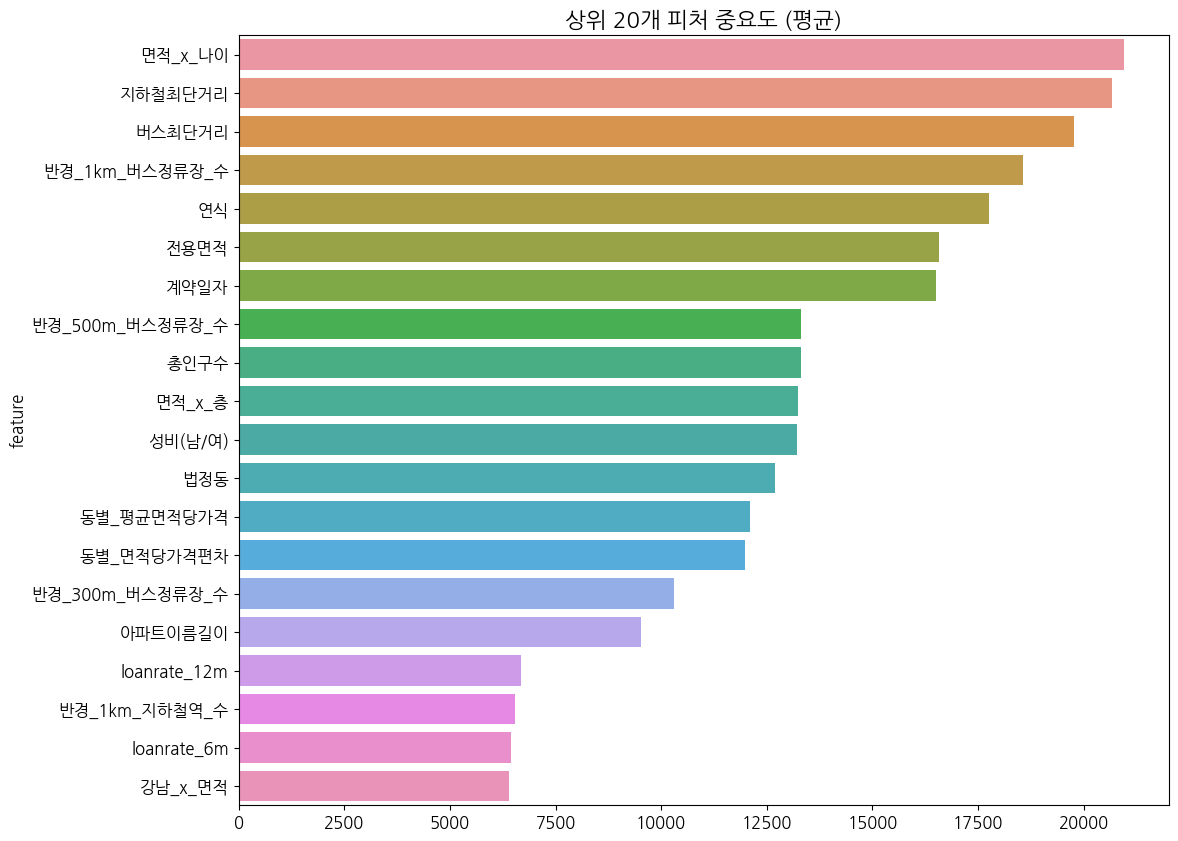

2025-07-16 19:10:02 | >> 피처 중요도 시각화 완료.
2025-07-16 19:10:02 | >> 2. 실제 값 vs OOF 예측 값 비교 시각화 중...


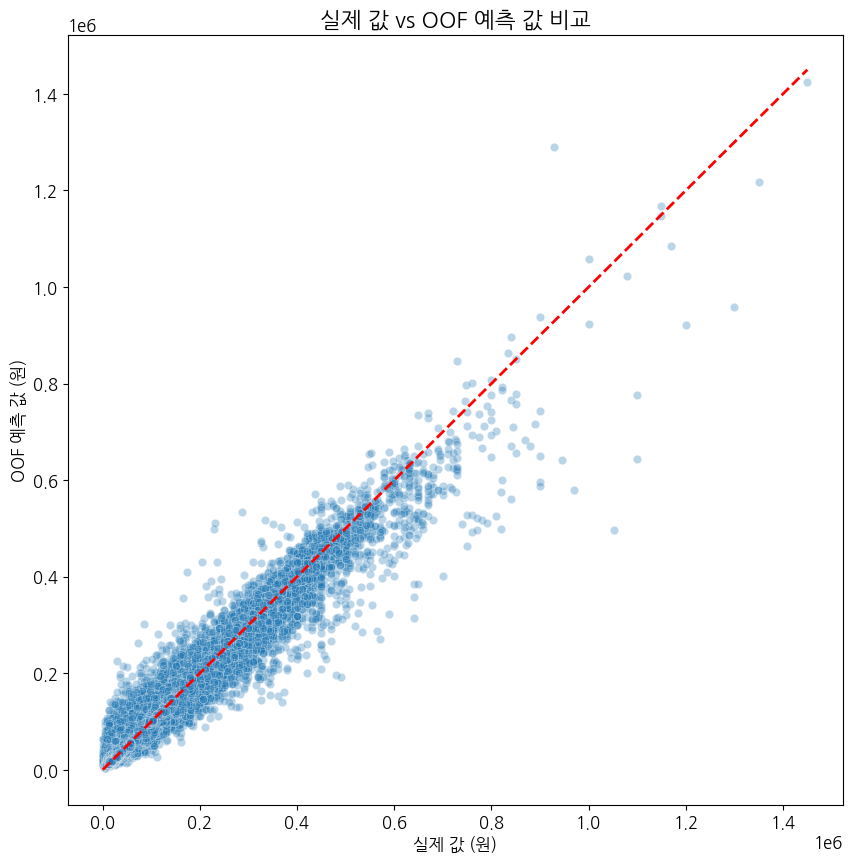

2025-07-16 19:10:04 | >> 실제 값 vs OOF 예측 값 비교 시각화 완료.
2025-07-16 19:10:04 | >> 3. 잔차 분포 확인 시각화 중...


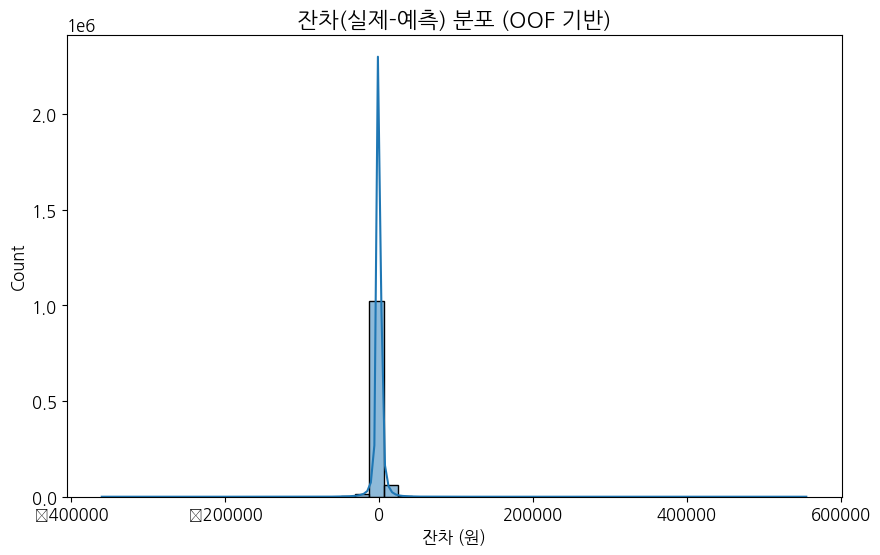

2025-07-16 19:10:06 | >> 잔차 분포 확인 시각화 완료.
2025-07-16 19:10:06 | >> 4. 학습/테스트 데이터 예측 분포 비교 시각화 중...


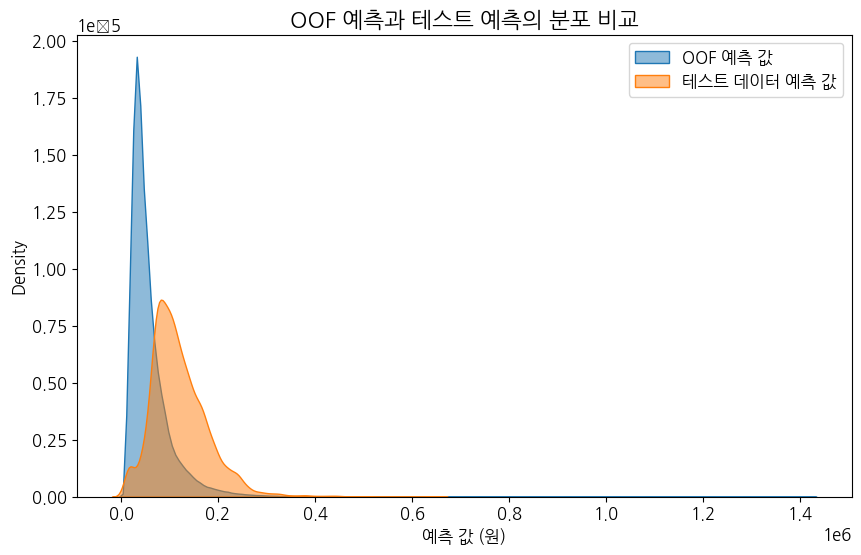

2025-07-16 19:10:08 | >> 학습/테스트 데이터 예측 분포 비교 시각화 완료.
2025-07-16 19:10:08 | >> 5. 주요 피처 간 상관관계 히트맵 시각화 중...


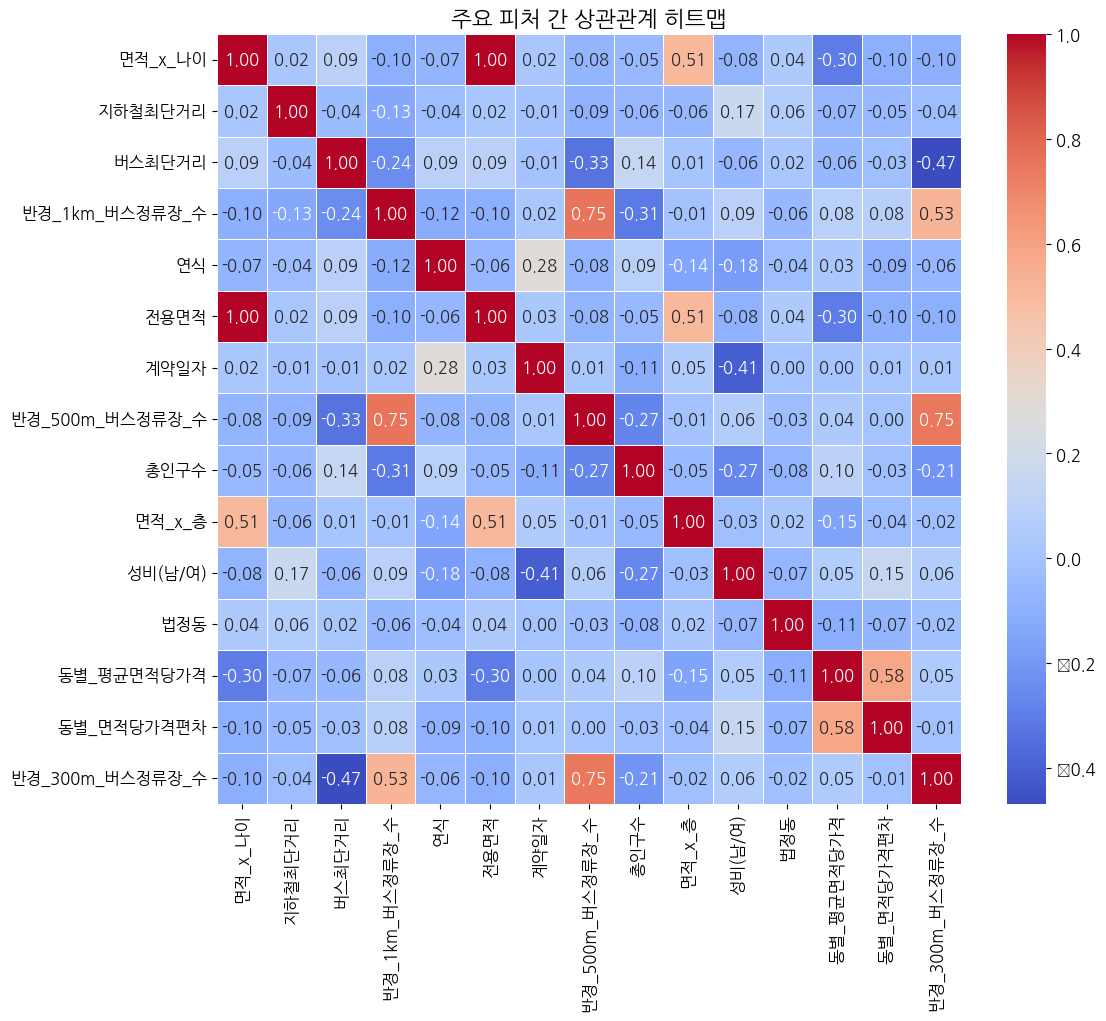

2025-07-16 19:10:09 | >> 피처 간 상관관계 히트맵 시각화 완료.
2025-07-16 19:10:09 | >> 6. 잔차 vs 예측값 플롯 시각화 중...


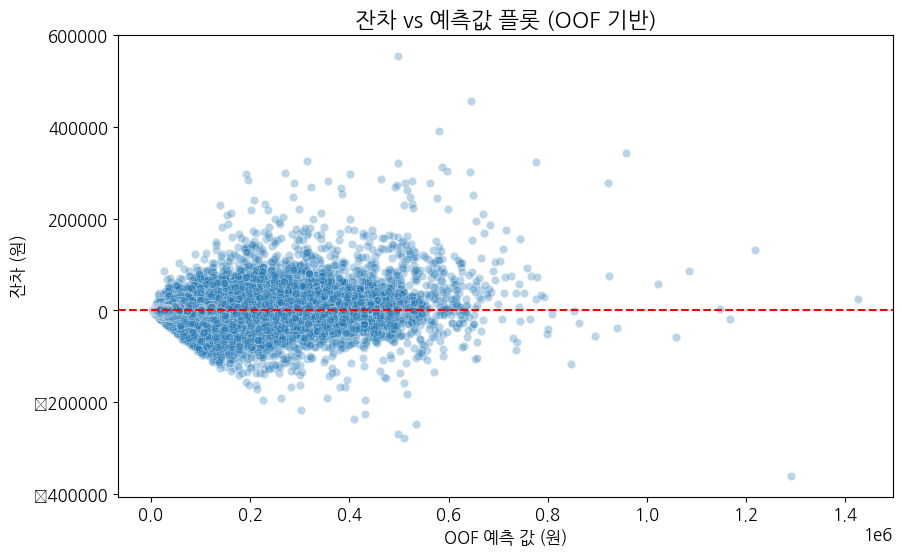

2025-07-16 19:10:10 | >> 잔차 vs 예측값 플롯 시각화 완료.
2025-07-16 19:10:10 | >> 7. 주요 피처와 타겟 변수 관계 시각화 중...


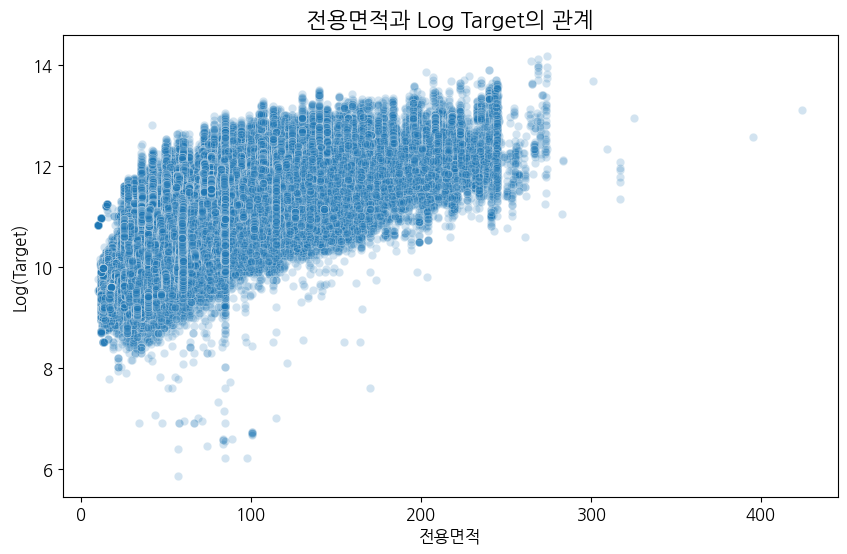

2025-07-16 19:10:11 | >> 주요 피처와 타겟 변수 관계 시각화 완료.
2025-07-16 19:10:11 | >> 8. SHAP 요약 플롯 분석 시작 (계산에 시간이 다소 소요될 수 있습니다)...


In [ ]:
# --- 9. 최종 모델 결과 시각화, 분석 및 이미지 저장 ---
# SHAP 및 os 라이브러리 임포트
import shap 
import os
from sklearn.model_selection import learning_curve # 학습 곡선 시각화를 위해 추가

if 'models' in locals() and 'oof_preds' in locals():
    # 이미지 저장 경로 설정 및 폴더 생성
    IMAGE_SAVE_DIR = '../../images/price_prediction_5'
    os.makedirs(IMAGE_SAVE_DIR, exist_ok=True)
    logger.write(f">> 시각화 결과가 저장될 경로: {IMAGE_SAVE_DIR}")

    logger.write(">> [9단계 시작] 모델 결과 시각화 및 분석 파일 저장을 시작합니다...")
    try:
        # 1. 피처 중요도 시각화
        logger.write(">> 1. 피처 중요도 이미지 저장 중...")
        feature_importances = pd.DataFrame()
        for i, model in enumerate(models):
            fold_importance = pd.DataFrame({
                'feature': X_train_selected.columns,
                'importance': model.feature_importances_,
                'fold': i + 1
            })
            feature_importances = pd.concat([feature_importances, fold_importance], axis=0)
        
        mean_importances = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
        
        plt.figure(figsize=(12, 10))
        sns.barplot(x=mean_importances.head(20).values, y=mean_importances.head(20).index)
        plt.title('상위 20개 피처 중요도 (평균)', fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '01_feature_importance.png'), bbox_inches='tight')
        plt.close() # 메모리 관리를 위해 plot을 닫아줍니다.
        logger.write(">> 피처 중요도 이미지 저장 완료.")

        # 2. 실제 값 vs OOF 예측 값 비교
        logger.write(">> 2. 실제 값 vs OOF 예측 값 비교 이미지 저장 중...")
        plt.figure(figsize=(10, 10))
        sns.scatterplot(x=np.expm1(y_train), y=np.expm1(oof_preds), alpha=0.3)
        plt.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], [np.expm1(y_train).min(), np.expm1(y_train).max()], 'r--', lw=2)
        plt.xlabel("실제 값 (원)", fontsize=12)
        plt.ylabel("OOF 예측 값 (원)", fontsize=12)
        plt.title('실제 값 vs OOF 예측 값 비교', fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '02_actual_vs_oof_scatter.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 실제 값 vs OOF 예측 값 비교 이미지 저장 완료.")

        # 3. 잔차(실제-예측) 분포 확인
        logger.write(">> 3. 잔차 분포 확인 이미지 저장 중...")
        residuals = np.expm1(y_train) - np.expm1(oof_preds)
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True, bins=50)
        plt.title('잔차(실제-예측) 분포 (OOF 기반)', fontsize=16)
        plt.xlabel("잔차 (원)", fontsize=12)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '03_residuals_distribution.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 잔차 분포 확인 이미지 저장 완료.")
        
        # 4. 학습 데이터와 테스트 데이터 예측 분포 비교
        logger.write(">> 4. OOF 예측과 테스트 예측의 분포 비교 이미지 저장 중...")
        plt.figure(figsize=(10, 6))
        sns.kdeplot(np.expm1(oof_preds), label='OOF 예측 값', fill=True, alpha=0.5)
        sns.kdeplot(test_preds, label='테스트 데이터 예측 값', fill=True, alpha=0.5)
        plt.title('OOF 예측과 테스트 예측의 분포 비교', fontsize=16)
        plt.xlabel("예측 값 (원)", fontsize=12)
        plt.legend()
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '04_prediction_distribution_comparison.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> OOF 예측과 테스트 예측의 분포 비교 이미지 저장 완료.")

        # 5. 피처 간 상관관계 히트맵
        logger.write(">> 5. 주요 피처 간 상관관계 히트맵 이미지 저장 중...")
        top_features = mean_importances.head(15).index
        corr_matrix = X_train_selected[top_features].corr()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title('주요 피처 간 상관관계 히트맵', fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '05_feature_correlation_heatmap.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 피처 간 상관관계 히트맵 이미지 저장 완료.")

        # 6. 잔차 vs 예측값 플롯
        logger.write(">> 6. 잔차 vs 예측값 플롯 이미지 저장 중...")
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=np.expm1(oof_preds), y=residuals, alpha=0.3)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel("OOF 예측 값 (원)", fontsize=12)
        plt.ylabel("잔차 (원)", fontsize=12)
        plt.title('잔차 vs 예측값 플롯 (OOF 기반)', fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '06_residuals_vs_predicted_plot.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 잔차 vs 예측값 플롯 이미지 저장 완료.")

        # 7. 주요 피처와 타겟 변수 관계 시각화
        logger.write(">> 7. 주요 피처와 타겟 변수 관계 이미지 저장 중...")
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=X_train_selected['전용면적'], y=y_train, alpha=0.2)
        plt.xlabel("전용면적", fontsize=12)
        plt.ylabel("Log(Target)", fontsize=12)
        plt.title('전용면적과 Log Target의 관계', fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '07_area_vs_log_target.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 주요 피처와 타겟 변수 관계 이미지 저장 완료.")

        # 8. SHAP 요약 플롯
        logger.write(">> 8. SHAP 요약 플롯 분석 및 저장 중...")
        explainer = shap.TreeExplainer(models[0])
        
        # 전체 데이터 대신 2000개의 샘플을 뽑아서 사용 (시간 단축)
        shap_sample = X_train_selected.sample(2000, random_state=42)
        shap_values = explainer.shap_values(shap_sample)

        shap.summary_plot(shap_values, X_train_selected, plot_type="dot", show=False)
        plt.title("SHAP 요약 플롯 (첫 번째 폴드 모델)", fontsize=16)
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '08_shap_summary_plot.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> SHAP 요약 플롯 저장 완료.")

        # 9. SHAP 의존성 플롯
        logger.write(">> 9. SHAP 의존성 플롯 저장 중...")
        top_3_features = mean_importances.head(3).index
        for feature in top_3_features:
            shap.dependence_plot(feature, shap_values, X_train_selected, interaction_index="auto", show=False)
            plt.title(f"SHAP Dependence Plot for '{feature}'", fontsize=16)
            plt.savefig(os.path.join(IMAGE_SAVE_DIR, f'09_shap_dependence_{feature}.png'), bbox_inches='tight')
            plt.close()
        logger.write(">> SHAP 의존성 플롯 저장 완료.")

        # 10. 학습 곡선 (Learning Curve)
        logger.write(">> 10. 학습 곡선 이미지 저장 중...")
        train_sizes, train_scores, validation_scores = learning_curve(
            estimator=lgb.LGBMRegressor(**best_params, verbosity=-1),
            X=X_train_selected,
            y=y_train,
            train_sizes=np.linspace(0.1, 1.0, 5),
            cv=3,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        train_scores_mean = -train_scores.mean(axis=1)
        validation_scores_mean = -validation_scores.mean(axis=1)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.title("학습 곡선 (Learning Curve)", fontsize=16)
        plt.xlabel("학습 데이터 샘플 수", fontsize=12)
        plt.ylabel("RMSE", fontsize=12)
        plt.legend(loc="best")
        plt.grid()
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '10_learning_curve.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 학습 곡선 이미지 저장 완료.")
        
        # 11. 그룹별 예측 오차 분석 (예: 자치구별 잔차)
        logger.write(">> 11. 자치구별 예측 오차 분석 및 저장 중...")
        residual_df = pd.DataFrame({'residuals': residuals, '자치구': train_df['자치구']})
        
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='자치구', y='residuals', data=residual_df)
        plt.xticks(rotation=90)
        plt.title('자치구별 예측 잔차 분포', fontsize=16)
        plt.xlabel("자치구", fontsize=12)
        plt.ylabel("잔차 (원)", fontsize=12)
        plt.grid()
        plt.savefig(os.path.join(IMAGE_SAVE_DIR, '11_error_distribution_by_district.png'), bbox_inches='tight')
        plt.close()
        logger.write(">> 자치구별 예측 오차 분석 저장 완료.")

        logger.write(">> [9단계 완료] 모든 시각화 및 분석 파일 저장 완료.")

    except Exception as e:
        logger.write(f">> [오류] 시각화 및 분석 파일 저장 중 문제가 발생했습니다: {e}", print_error=True)

In [15]:
# --- 10. 최종 예측 및 제출 파일 생성 ---
if 'test_preds' in locals():
    logger.write(">> [10단계 시작] 최종 제출 파일 생성을 시작합니다...")
    try:
        # 최종 모델로 전체 데이터 학습
        logger.write(">> 전체 훈련 데이터로 최종 모델 학습 시작...")
        final_model = lgb.LGBMRegressor(**best_params)
        final_model.fit(X_train_selected, y_train)
        logger.write(">> 최종 모델 학습 완료.")
        
        # 모델 저장
        joblib.dump(final_model, MODEL_PATH)
        logger.write(f">> 모델 저장 완료: {MODEL_PATH}")

        # 제출 파일 생성
        logger.write(">> 'target' 컬럼만 포함된 제출 파일을 생성합니다.")
        submission_df = pd.DataFrame({'target': test_preds})
        submission_df['target'] = submission_df['target'].astype(int)
        
        submission_df.to_csv(SUBMISSION_PATH, index=False)
        logger.write(f">> 제출 파일 생성 완료: {SUBMISSION_PATH}")
        
    except Exception as e:
        logger.write(f">> [오류] 제출 파일 생성 중 문제 발생: {e}", print_error=True)
    
    logger.write(">> 모델링 종료")
    logger.write("="*50 + "\n")
    #logger.close()

2025-07-16 16:55:13 | >> [10단계 시작] 최종 제출 파일 생성을 시작합니다...
2025-07-16 16:55:13 | >> 전체 훈련 데이터로 최종 모델 학습 시작...
2025-07-16 17:12:24 | >> 최종 모델 학습 완료.
2025-07-16 17:12:24 | >> 모델 저장 완료: ../../model/price_prediction_5_model.pkl
2025-07-16 17:12:24 | >> 'target' 컬럼만 포함된 제출 파일을 생성합니다.
2025-07-16 17:12:24 | >> 제출 파일 생성 완료: ../../data/processed/submissions/price_prediction_5_submission.csv
2025-07-16 17:12:24 | >> 모델링 종료
2025-07-16 17:12:24 | ==================================================
